## Step 1 – Load Image Dataset & Show Class Counts

In [25]:
import tensorflow as tf

# Load datasets from the clean 'split' folder
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/split/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/split/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/split/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

# Confirm classes
class_names = train_ds.class_names
print("Class names:", class_names)

Found 38791 files belonging to 39 classes.
Found 8318 files belonging to 39 classes.
Found 8339 files belonging to 39 classes.
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold

## !Check Class Counts (Simple Check)

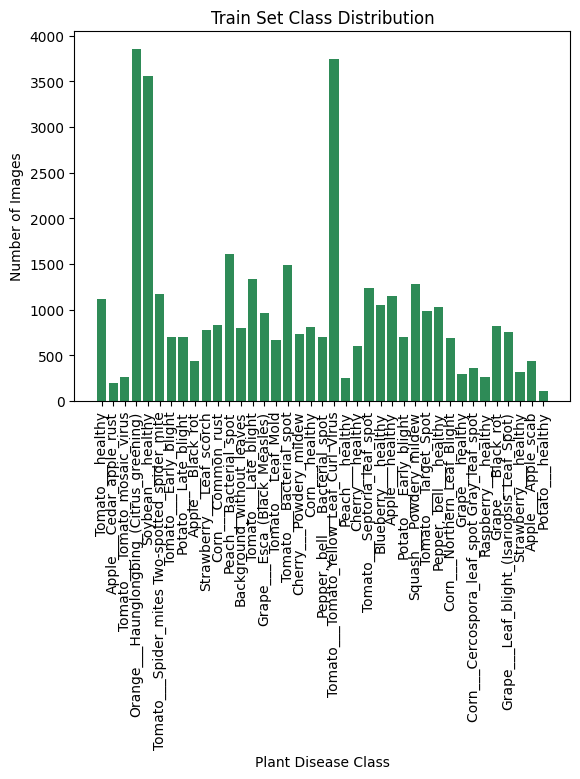

In [26]:
import matplotlib.pyplot as plt

# Count how many samples per class (in train set)
label_counts = {}

for images, labels in train_ds.unbatch():
    class_idx = tf.argmax(labels).numpy()
    class_name = class_names[class_idx]
    label_counts[class_name] = label_counts.get(class_name, 0) + 1

# Bar chart
plt.bar(label_counts.keys(), label_counts.values(), color="seagreen")
plt.xticks(rotation=90)
plt.title("Train Set Class Distribution")
plt.xlabel("Plant Disease Class")
plt.ylabel("Number of Images")
plt.show()

## Step 2 – Data Augmentation (Training Only)

In [27]:
from tensorflow.keras import layers
import tensorflow as tf
# Augmentation block
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

AUTOTUNE = tf.data.AUTOTUNE

# SAFE dataset pipeline
def prepare_dataset(dataset, augment=False):
    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                              num_parallel_calls=AUTOTUNE)
    return dataset.shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Apply
train_ds_aug = prepare_dataset(train_ds, augment=True)
val_ds_prep = prepare_dataset(val_ds)
test_ds_prep = prepare_dataset(test_ds)

## !Visualize Augmented Images

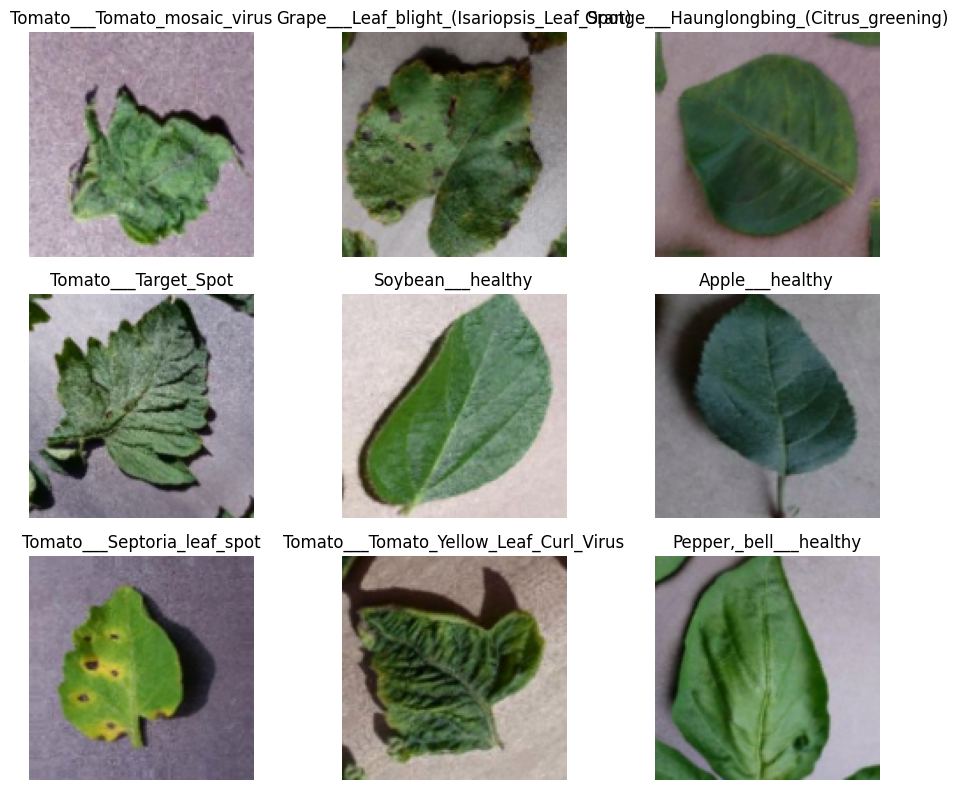

In [28]:
import matplotlib.pyplot as plt

# Take a few sample images directly from unbatched train_ds
sample_images = []
sample_labels = []

for img, label in train_ds.unbatch().take(9):  # Just 9 images
    sample_images.append(img)
    sample_labels.append(label)

plt.figure(figsize=(10, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    
    # Apply augmentation ON SINGLE IMAGE
    augmented_img = data_augmentation(tf.expand_dims(sample_images[i], 0), training=True)
    
    plt.imshow(augmented_img[0].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(sample_labels[i]).numpy()])
    plt.axis("off")

plt.tight_layout()
plt.show()


## Step 3 – Build the CNN Model

In [29]:
from tensorflow.keras import models, layers, regularizers

# Get number of output classes
num_classes = len(class_names)

# Build a simple CNN model
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show summary
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape  ┃ Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ conv2d_12 (Conv2D)  │ (None, 126,   │     896 │
│                     │ 126, 32)      │         │
├─────────────────────┼───────────────┼─────────┤
│ max_pooling2d_12    │ (None, 63,    │       0 │
│ (MaxPooling2D)      │ 63, 32)       │         │
├─────────────────────┼───────────────┼─────────┤
│ conv2d_13 (Conv2D)  │ (None, 61,    │  18,496 │
│                     │ 61, 64)       │         │
├─────────────────────┼───────────────┼─────────┤
│ max_pooling2d_13    │ (None, 30,    │       0 │
│ (MaxPooling2D)      │ 30, 64)       │         │
├─────────────────────┼───────────────┼─────────┤
│ conv2d_14 (Conv2D)  │ (None, 28,    │  73,856 │
│                     │ 28, 128)      │         │
├─────────────────────┼───────────────┼─────────┤
│ max_pooling2d_14    │ (None, 14,    │       0 │
│ (MaxPooling2D)      │ 14, 128)      │         │
├─────────────────────┼───────────────┼─────────┤
│ flatten_4 (Flatten) │ (None, 25088) │       0 │
├─────────────────────┼───────────────┼─────────┤
│ dense_8 (Dense)     │ (None, 256)   │ 6,422,… │
├─────────────────────┼───────────────┼─────────┤
│ dropout_4 (Dropout) │ (None, 256)   │       0 │
├─────────────────────┼───────────────┼─────────┤
│ dense_9 (Dense)     │ (None, 39)    │  10,023 │
└─────────────────────┴───────────────┴─────────┘

 Total params: 6,526,055 (24.89 MB)

 Trainable params: 6,526,055 (24.89 MB)

 Non-trainable params: 0 (0.00 B)

## Step 4 – Train the Model (with EarlyStopping & ModelCheckpoint)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
checkpoint_cb = ModelCheckpoint(
    "../models/best_model.h5", 
    monitor="val_accuracy", 
    save_best_only=True, 
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_ds_aug,
    validation_data=val_ds_prep,
    epochs=20,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/20
